In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from itertools import product
from tqdm import tqdm

import seaborn as sns
import time
import math

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import notebook
from xgboost import XGBRegressor

import yfinance as yf

In [3]:
# ads = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/ads.csv", index_col=["Time"], parse_dates=["Time"])
# currency = pd.read_csv(
#     "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/currency.csv", index_col=["Time"], parse_dates=["Time"]
# )
ads = pd.read_csv("data/ads.csv", index_col=["Time"], parse_dates=["Time"])
currency = pd.read_csv(
    "data/currency.csv", index_col=["Time"], parse_dates=["Time"])

In [4]:
# ads.to_csv('data/ads.csv', index=True)
# currency.to_csv('data/currency.csv', index=True)

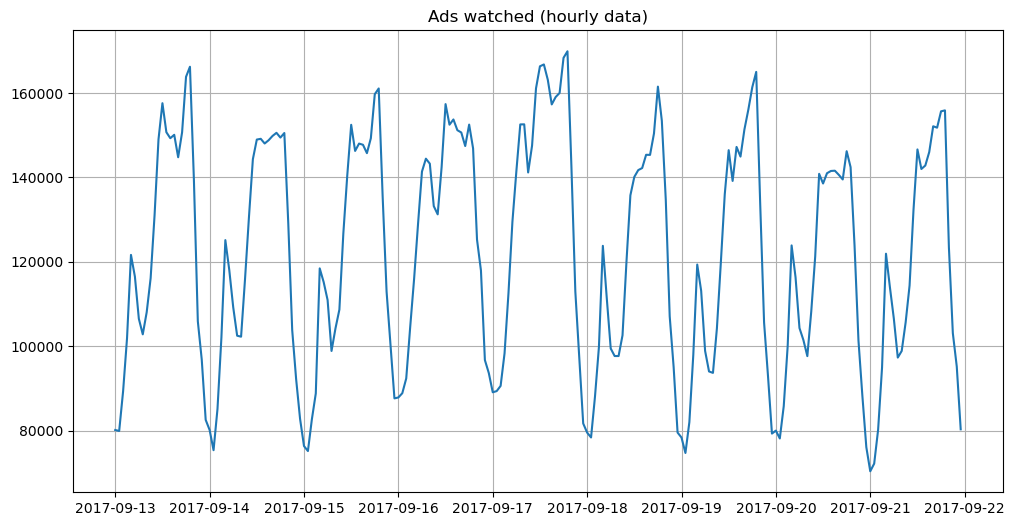

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title("Ads watched (hourly data)")
plt.grid(True)
# plt.savefig("../Presentation/img/ads.png")
plt.show()

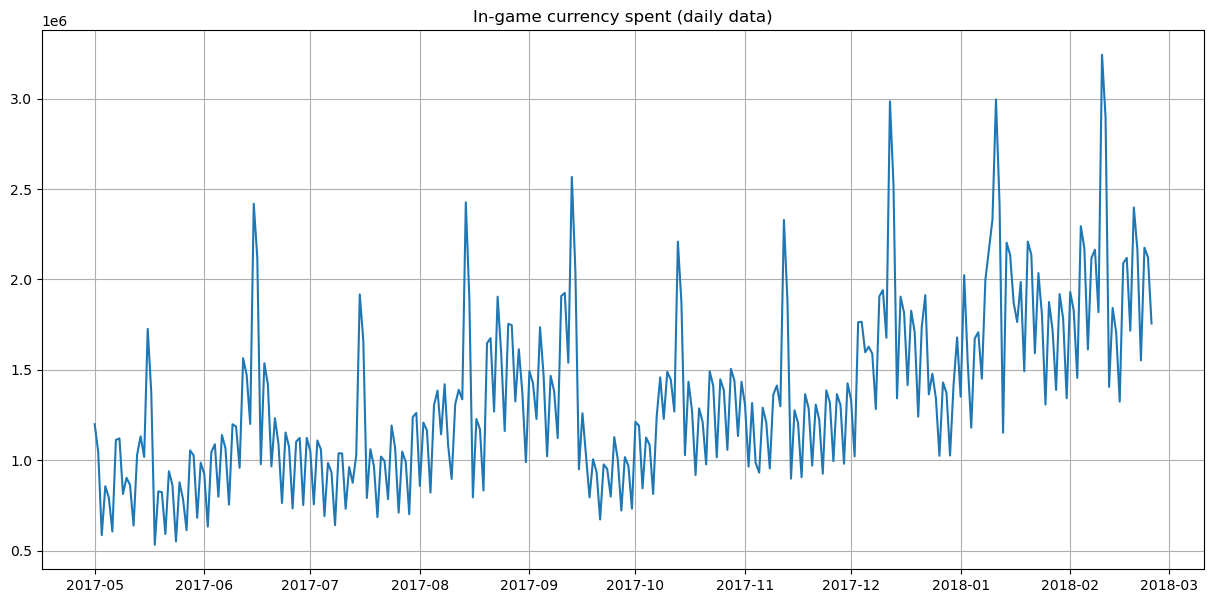

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title("In-game currency spent (daily data)")
plt.grid(True)
# plt.savefig("../Presentation/img/currency_spent.png")
plt.show()

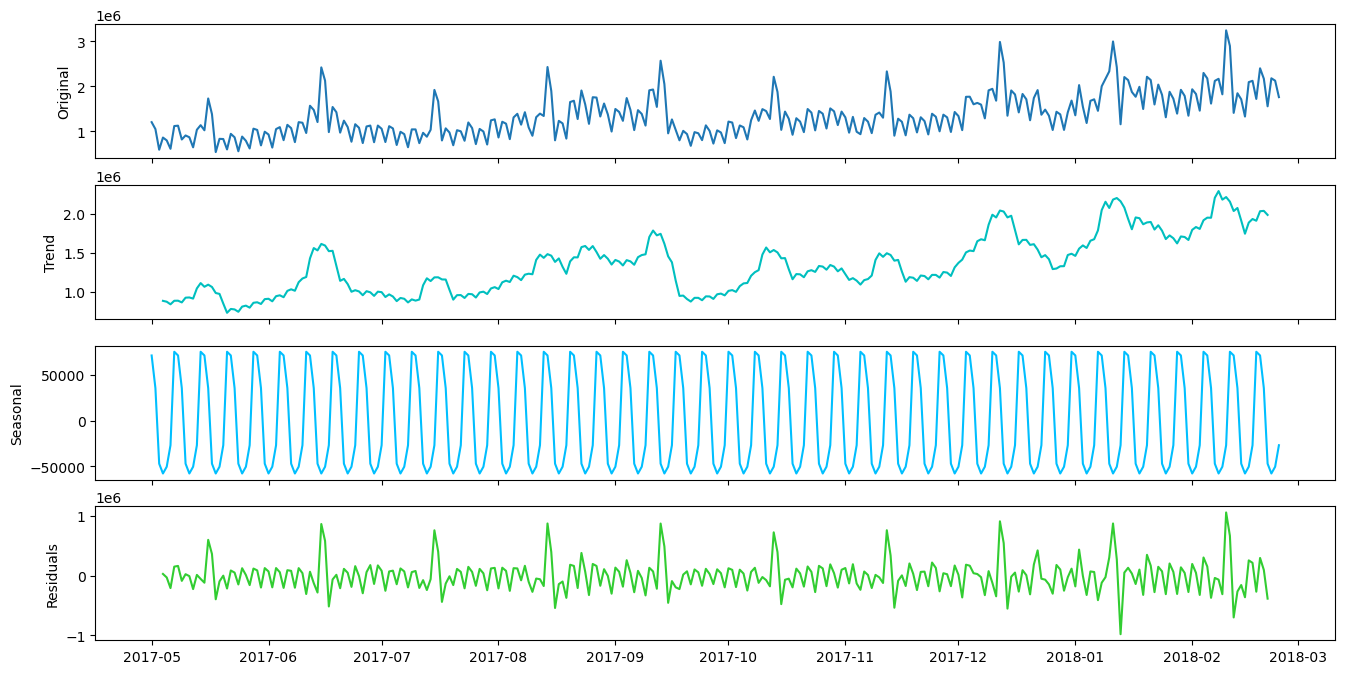

In [7]:


from statsmodels.tsa.seasonal import seasonal_decompose

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 8))
series = currency.GEMS_GEMS_SPENT
result = seasonal_decompose(series, model='additive')
axs[0].plot(result.observed)
axs[0].set_ylabel('Original')
axs[1].plot(result.trend, color='c')
axs[1].set_ylabel('Trend')
axs[2].plot(result.seasonal, color='deepskyblue')
axs[2].set_ylabel('Seasonal')
axs[3].plot(result.resid, color='limegreen')
axs[3].set_ylabel('Residuals')
# fig.savefig('../Presentation/img/decomposition.png', dpi=300)
plt.show()

# Сглаживание

## Скользящее среднее

Начнем моделирование с наивного предположения — "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней.
$$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$$

Для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной - такой прогноз бесполезен, но у скользящей средней есть другое применение — сглаживание исходного ряда для выявления трендов. 

В пандасе есть готовая реализация — `DataFrame.rolling(window).mean()`. Чем больше зададим ширину интервала — тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь с определением общих паттернов.

In [8]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [9]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [10]:
colors = ['green', 'orange']
windows = [4, 12]
for color, index in enumerate(windows):
    print(color, index)

0 4
1 12


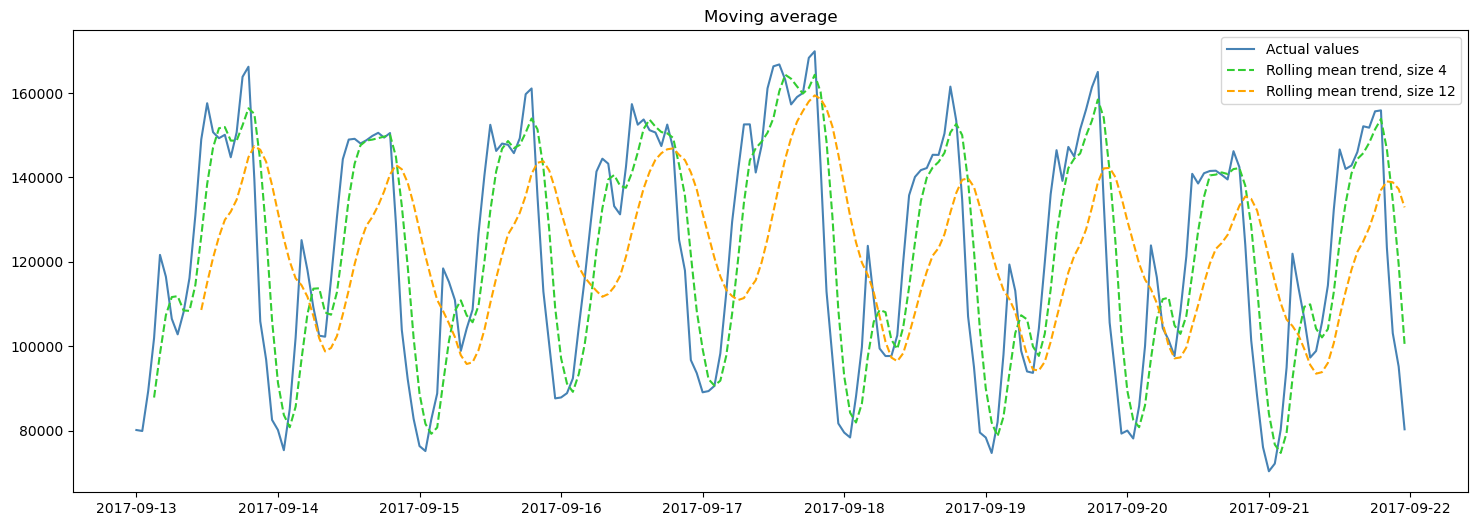

In [11]:

windows = [4, 12]
plt.figure(figsize=(18, 6))
plt.title("Moving average")
plt.plot(ads, linestyle='-', color='steelblue', label="Actual values")
colors = ['limegreen', 'orange']
for index, window in enumerate(windows):
    plt.plot(ads.rolling(window=window).mean(), linestyle='--', color=colors[index], label=f"Rolling mean trend, size {window}")
plt.legend()
# plt.savefig('../Presentation/img/moving_average.png')
plt.show()

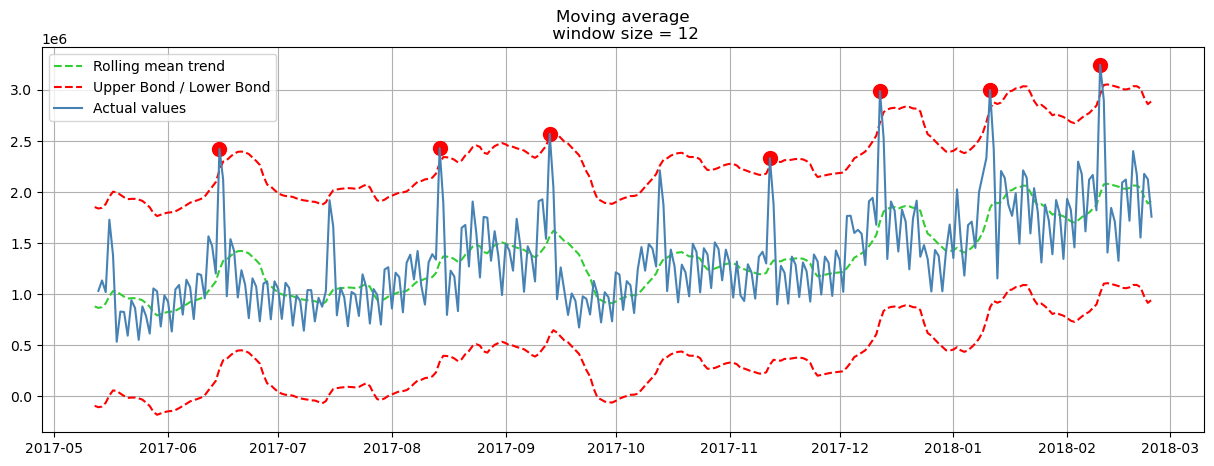

In [12]:
plot_intervals=True
scale=1.96
plot_anomalies=True
series = currency

rolling_mean = series.rolling(window=window).mean()

plt.figure(figsize=(15, 5))
plt.title("Moving average\n window size = {}".format(window))
plt.plot(rolling_mean, color='limegreen', linestyle='--', label="Rolling mean trend")

# Plot confidence intervals for smoothed values
if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

# Having the intervals, find abnormal values
if plot_anomalies:
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series < lower_bond] = series[series < lower_bond]
    anomalies[series > upper_bond] = series[series > upper_bond]
    plt.plot(anomalies, "ro", markersize=10)

plt.plot(series[window:], color='steelblue', label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)

## Взвешенная средняя

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес.

$$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$

## Экспоненциальная взвешенная

если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого экспоненциального сглаживания:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$$


Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд.

Экспоненциальность скрывается в рекурсивности функции — каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [13]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [14]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(
            exponential_smoothing(series, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(series.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)
    plt.show()

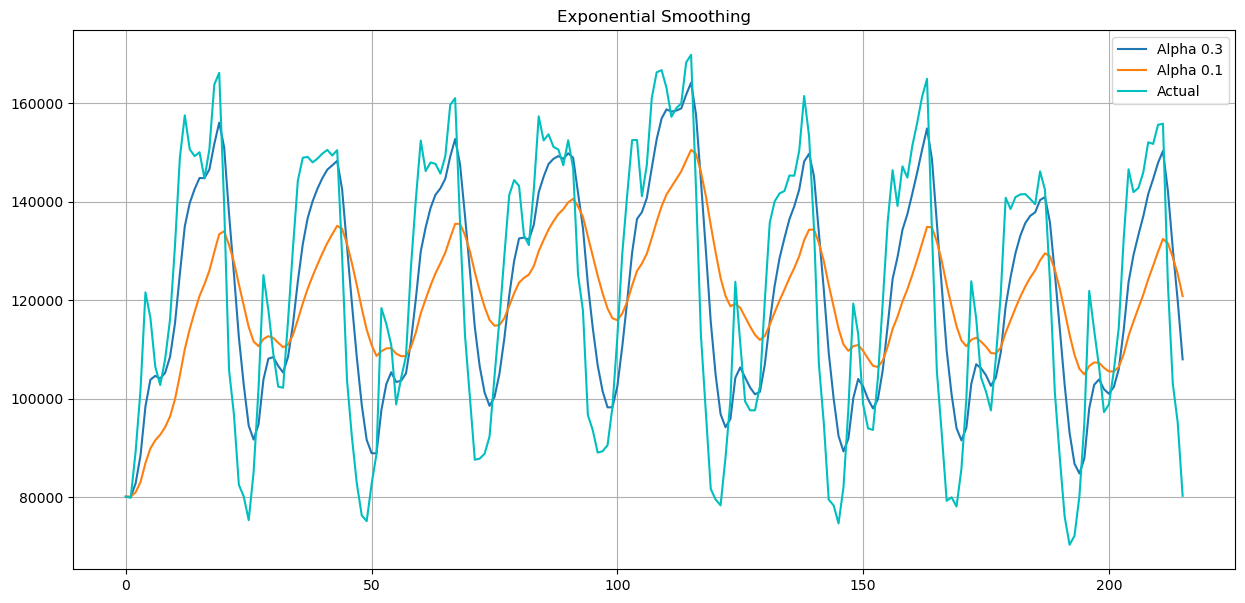

In [15]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.1])

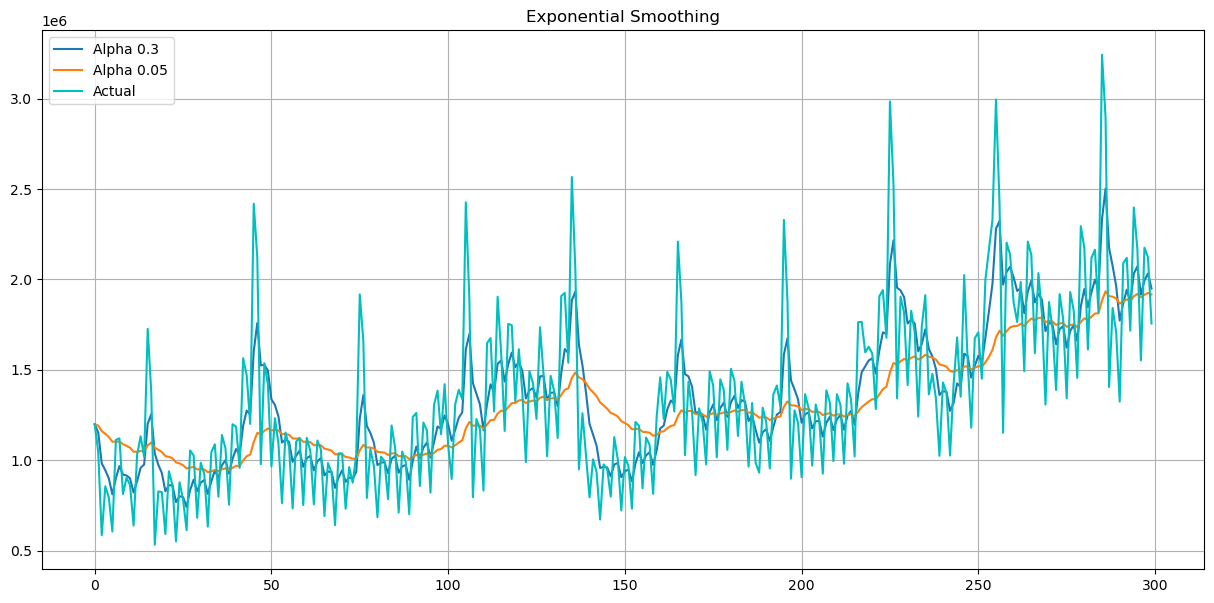

In [16]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

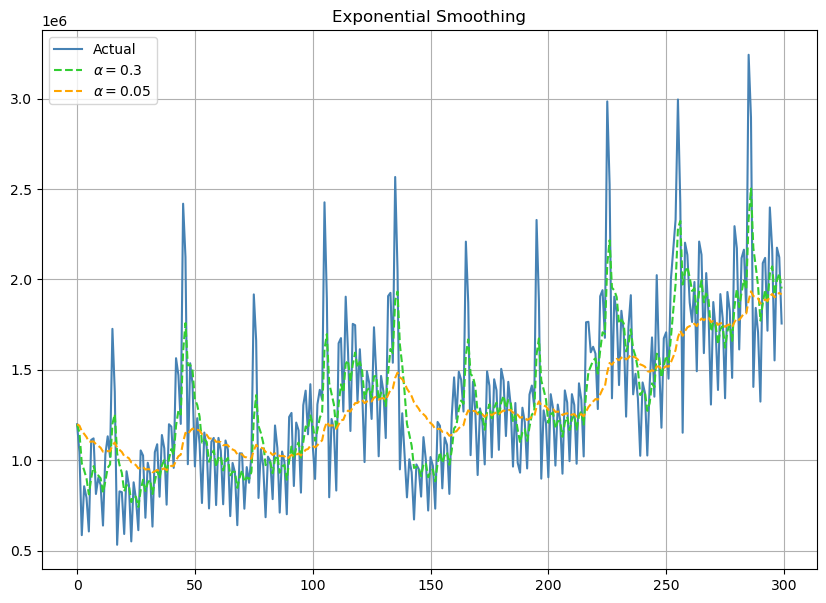

In [17]:
plt.figure(figsize=(10, 7))
alphas = [0.3, 0.05]
colors = ['limegreen', 'orange']
plt.plot(currency.GEMS_GEMS_SPENT.values, color='steelblue', label="Actual")
for index, alpha in enumerate(alphas):
    plt.plot(
        exponential_smoothing(currency.GEMS_GEMS_SPENT, alpha), linestyle='--',color=colors[index], label=r"$\alpha = ${}".format(alpha)
    )
plt.legend(loc="best")
plt.axis("tight")
plt.title("Exponential Smoothing")
plt.grid(True)
# plt.savefig('../Presentation/img/exponential_smoothing.png')
plt.show()

## Двойное экспоненциальное сглаживание

разбиение ряда на две составляющие — уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$ \ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})\\ b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\\ \hat{y}_{x+1} = \ell_x + b_x $$


В результате получаем набор функций. Первая описывает уровень — он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд — он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [18]:
def double_exponential_smoothing(series, alpha, beta):
    """
    :param series:  dataset with timeseries
    :param alpha:   float [0.0, 1.0], smoothing parameter for level
    :param beta:    float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        # forecasting
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level = level
        level = alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

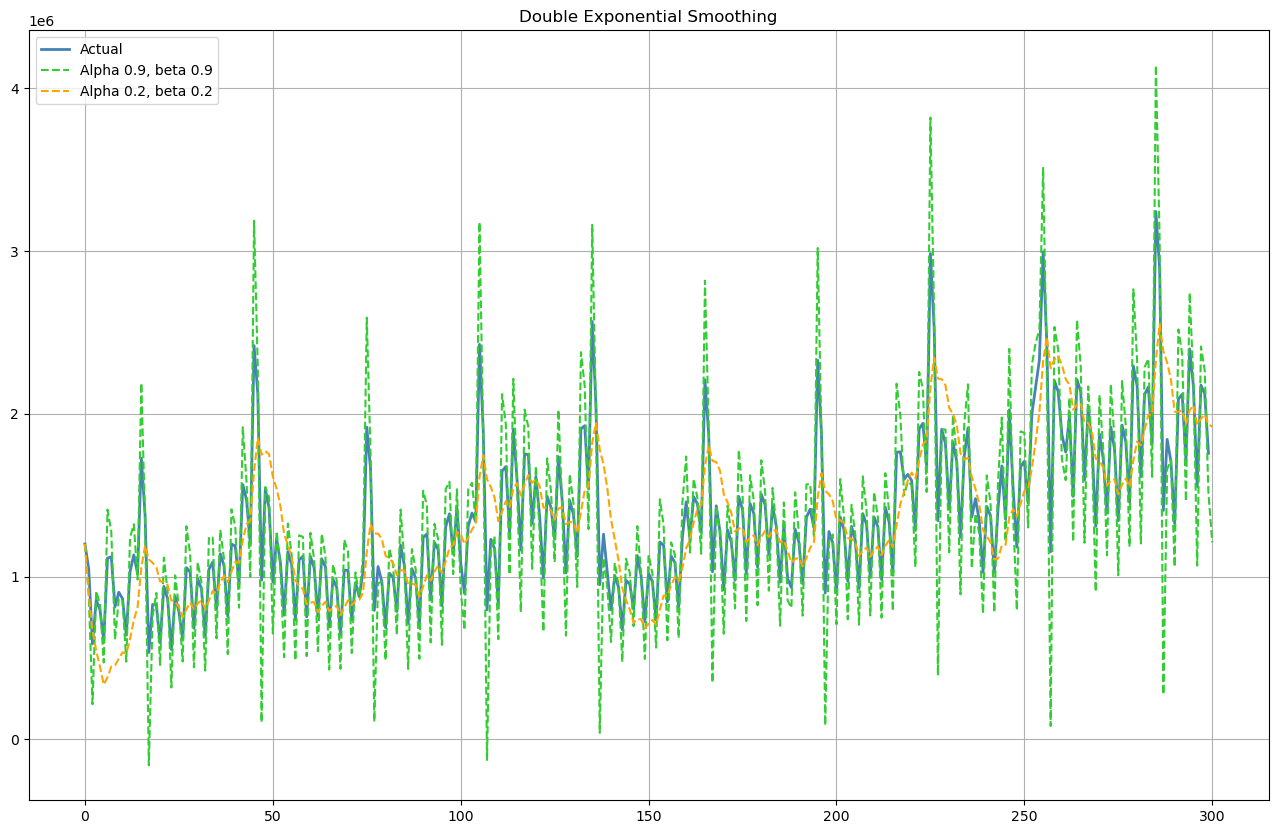

In [19]:
alphas=[0.9]
betas=[0.9]
params = [(0.9, 0.9), (0.2, 0.2)]
colors = ['limegreen', 'orange']
plt.figure(figsize=(16, 10))
plt.plot(currency.GEMS_GEMS_SPENT.values, color='steelblue', linewidth=2, label = "Actual")

for index, (alpha, beta) in enumerate(params):
    plt.plot(double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alpha, beta), 
            linestyle='--', 
            color=colors[index],
            label="Alpha {}, beta {}".format(alpha, beta))
plt.legend(loc="best")
plt.axis('tight')
plt.title("Double Exponential Smoothing")
plt.grid(True)
# plt.savefig('../Presentation/img/double_exp_smoothing.png', dpi=300)
plt.show()

## Тройное экспоненциальное сглаживание

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    :param series:          initial time series
    :param slen:            length of a season
    :param alpha:           Holt-Winters model coefficient
    :param beta:            Holt-Winters model coefficient
    :param gamma:           Holt-Winters model coefficient
    :param n_preds:         predictions horizon
    :param scaling_factor:  sets the width of the confidence interval by Brutlag (usually, values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum_ = 0.0
        for i in range(self.slen):
            sum_ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum_ / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

def plotHoltWinters(series, model, n_test_points=0, plot_intervals=False, plot_anomalies=False):
    """
    :param series:          Dataset with timeseries
    :type series:            pd.Series
    :param model:           HoltWinters model
    :type model:             HoltWinters
    :param plot_intervals:  Plot confidence intervals
    :type plot_intervals:    bool
    :param plot_anomalies:  Plot anomalies
    :type plot_anomalies:    bool
    """
    
    plt.figure(figsize=(16, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-n_test_points, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

# TimeSeries Cross validation

In [22]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
    Returns error on CV
    :param params:         Vector of parameters for optimization
    :type params:           (int, int, int)
    :param series:         Dataset with timeseries
    :type series:           pd.Series
    :param loss_function:  Loss function in the same from as losses from sklearn
    :type loss_function:    function
    :param slen:           Season length for Holt-Winters model
    :type slen:             int
    """
    assert type(series)==pd.Series, "series has to be pd.Series"
    
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train],
                            slen=slen, 
                            alpha=alpha,
                            beta=beta,
                            gamma=gamma,
                            n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
    
    return np.mean(np.array(errors))

def find_optimal_HW_parameteres(data, slen):
    # initializing model parameters alpha, beta and gamma
    init_params = [0, 0, 0] 
    param_bounds = ((0, 1), (0, 1), (0, 1))

    # Minimizing the loss function 
    opt = minimize(timeseriesCVscore,
                   x0=init_params,
                   args=(data, mean_squared_error, slen),
                   method="TNC",
                   bounds=param_bounds)

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x
    
    #print("Alpha =", alpha_final)
    #print("Beta  =", beta_final)
    #print("Gamma =", gamma_final)
    
    return alpha_final, beta_final, gamma_final

In [23]:
df_a = pd.read_csv("./data/air.csv", sep=",", index_col=0)
df_a = df_a.rename(columns={"#Passengers": "x"})

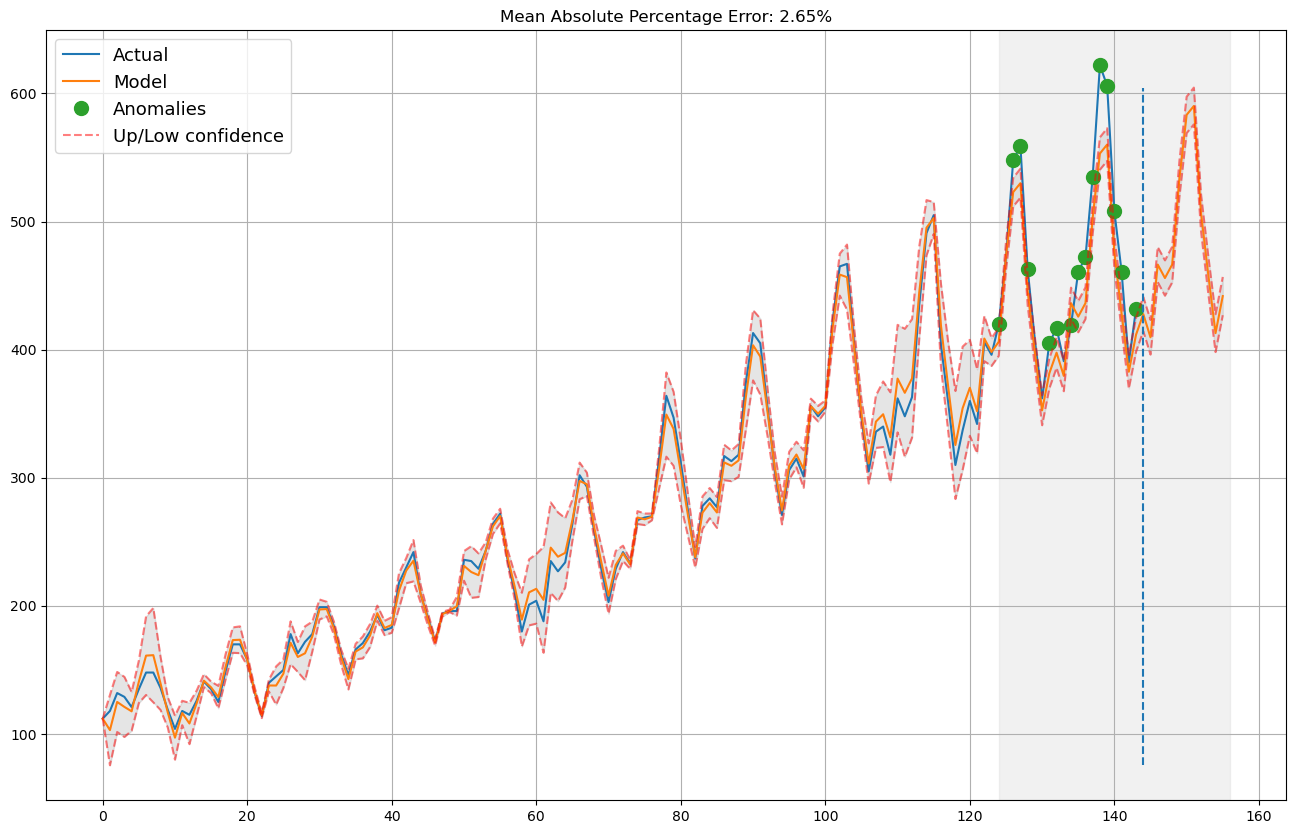

In [24]:
n_test_points = 20
data = df_a.x[:-n_test_points] # leave some data for testing
SLEN = 12

alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)

model = HoltWinters(data,
                    slen=SLEN, 
                    alpha=alpha_final, 
                    beta=beta_final, 
                    gamma=gamma_final, 
                    n_preds=n_test_points+SLEN,
                    scaling_factor=3)
model.triple_exponential_smoothing()

plotHoltWinters(df_a.x, model, n_test_points=n_test_points, plot_intervals=True, plot_anomalies=True)

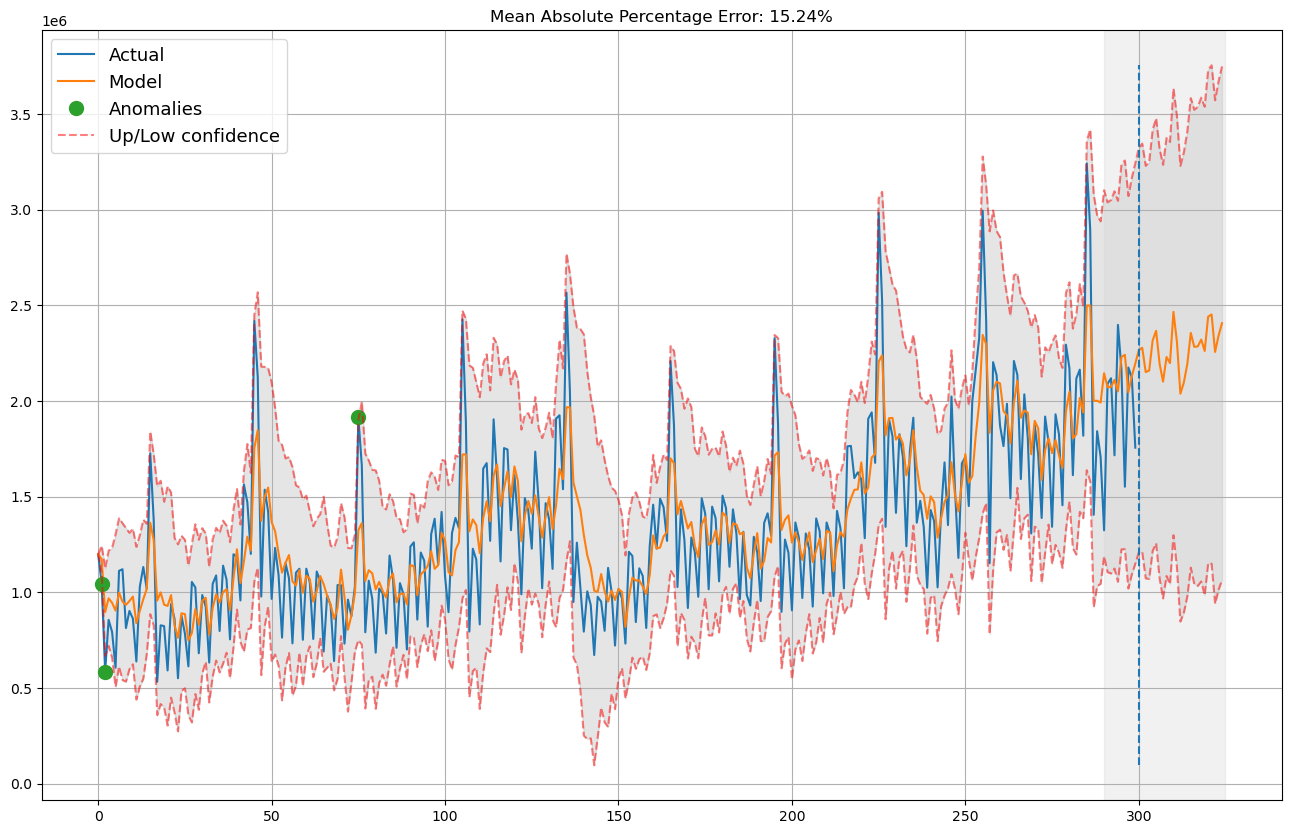

In [25]:
n_test_points = 10
data = currency.GEMS_GEMS_SPENT[:-n_test_points] # leave some data for testing
SLEN = 25

alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)

model = HoltWinters(data,
                    slen=SLEN, 
                    alpha=alpha_final, 
                    beta=beta_final, 
                    gamma=gamma_final, 
                    n_preds=n_test_points+SLEN,
                    scaling_factor=3)
model.triple_exponential_smoothing()

plotHoltWinters(currency.GEMS_GEMS_SPENT, model, n_test_points=n_test_points, plot_intervals=True, plot_anomalies=True)
# plt.savefig('../Presentation/img/time_series_forecast.png')

# ARIMA model

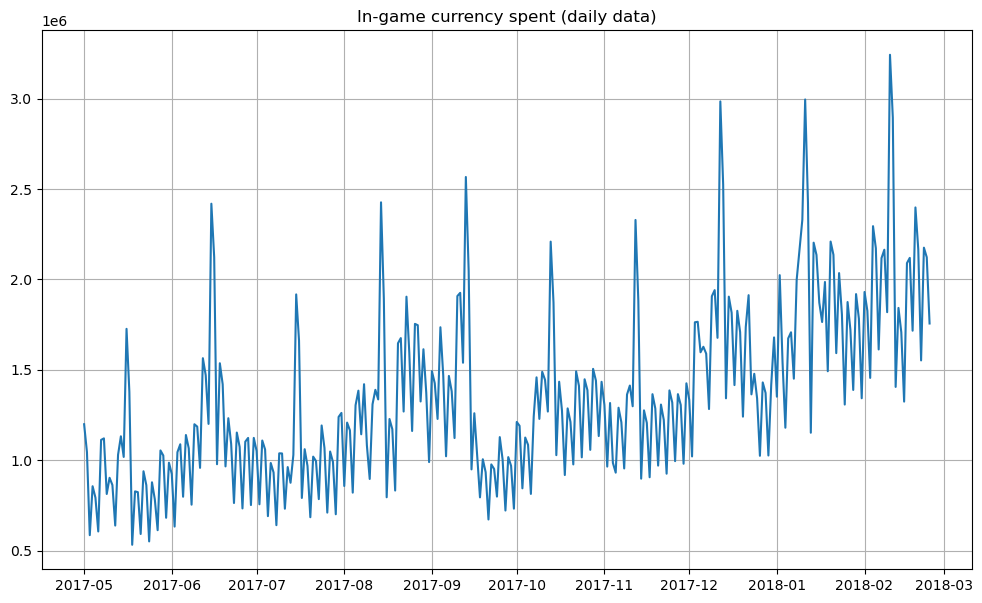

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title("In-game currency spent (daily data)")
plt.grid(True)
plt.show()

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция `jarque_bera()`, которая возвращает значения данной статистики.

In [27]:
row =  [u'p-value']
jb_test = sm.stats.stattools.jarque_bera(currency.GEMS_GEMS_SPENT)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

     p-value      
------------------
53.965327856385606
------------------


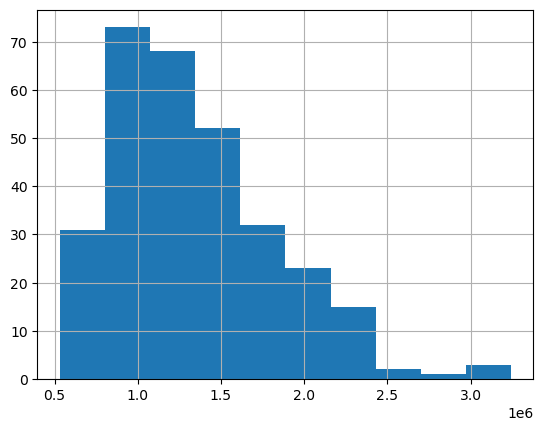

In [28]:
currency.GEMS_GEMS_SPENT.hist()
plt.show()

Проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле `statsmodels` есть функция `adfuller()`

In [29]:
test = sm.tsa.adfuller(currency.GEMS_GEMS_SPENT)
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical value 5%: {test[4]["5%"]}')
if test[1]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')


adf: -1.8160113962891062
p-value: 0.37254195189457745
Critical value 5%: -2.8717352599720294
есть единичные корни, ряд не стационарен


Проверим порядок интегрированности ряда:

In [30]:
currency1diff = currency.GEMS_GEMS_SPENT.diff(periods=1).dropna()
test = sm.tsa.adfuller(currency1diff)
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -6.007482880105367
p-value: 1.6026136773022e-07
Critical values: {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}
единичных корней нет, ряд стационарен


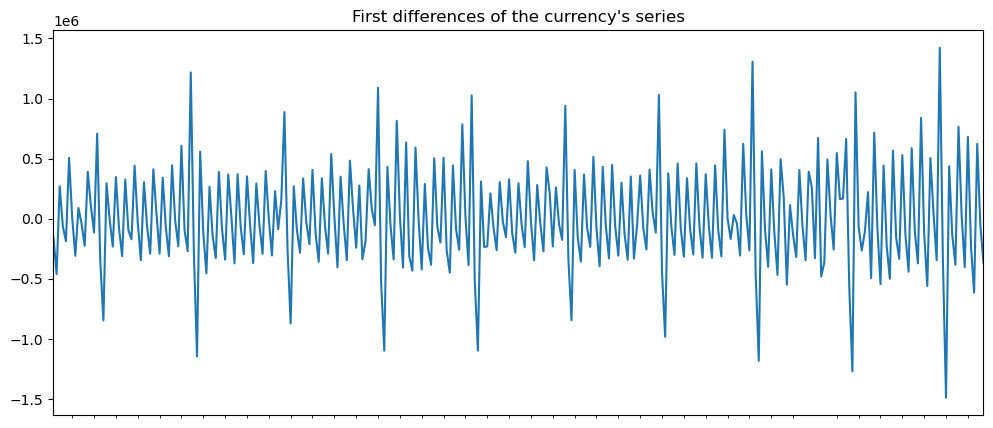

In [31]:
currency.GEMS_GEMS_SPENT.diff(periods=1).dropna().plot(figsize=(12,5))
plt.xlabel('')
plt.xticks([])
plt.title('First differences of the currency\'s series')
# plt.savefig('../Presentation/img/first_differences_of_the_currency_series.png')
plt.show()

У нас отсутствует тренд, но есть небольшие колебания дисперсии. В первом приближении будем считать ряд стационарным.

Для моделирования построим модель ARIMA для первых разностей.

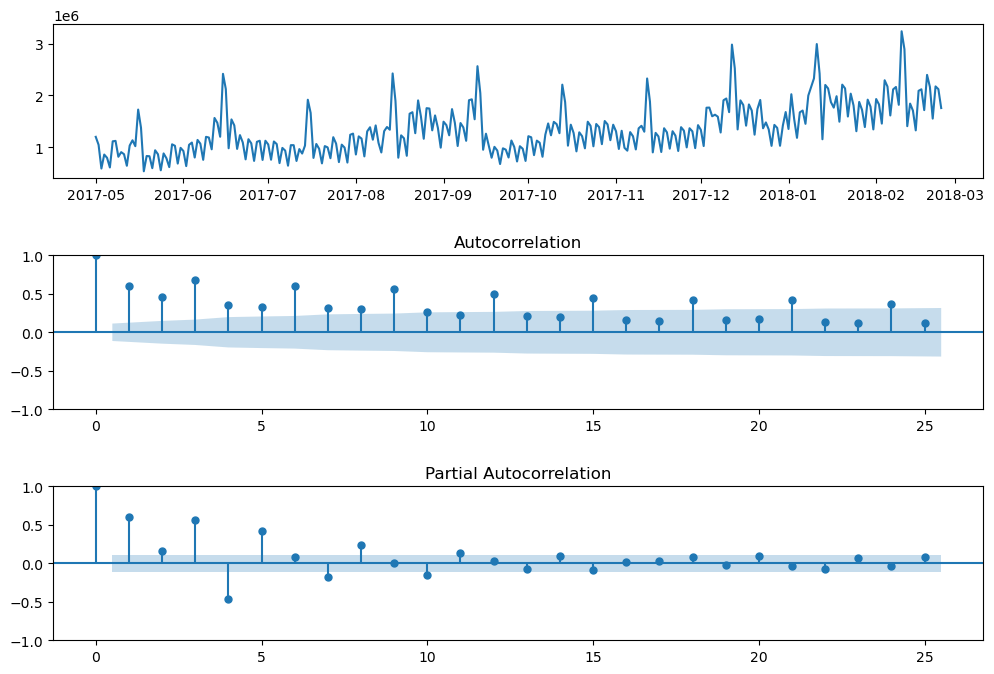

In [32]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(311)
ax1.plot(currency.GEMS_GEMS_SPENT)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(currency.GEMS_GEMS_SPENT, lags=25, ax=ax2)
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(currency.GEMS_GEMS_SPENT, lags=25, ax=ax3)
# fig.savefig('../Presentation/img/acf_pacf.png', dpi=300)
plt.show()

In [33]:
src_data_model = currency.GEMS_GEMS_SPENT[:'2018-02-01']
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='d').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:        GEMS_GEMS_SPENT   No. Observations:                  277
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3916.222
Date:                Fri, 01 Mar 2024   AIC                           7838.443
Time:                        12:30:45   BIC                           7849.304
Sample:                    05-01-2017   HQIC                          7842.801
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1791      0.117      1.528      0.127      -0.051       0.409
ma.L1         -0.8208      0.050    -16.499      0.000      -0.918      -0.723
sigma2      1.531e+11   9.47e-14   1.62e+24      0.0

/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.

Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью `statsmadels` это можно сделать так:

In [34]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

        Q-stat        p-value
0     0.129996   7.184357e-01
1    10.026188   6.650297e-03
2    74.912821   3.782606e-16
3    91.709874   5.704391e-19
4   111.319135   2.156161e-22
5   170.403845   3.692646e-34
6   186.078982   1.012172e-36
7   201.937691   2.495543e-39
8   262.582437   2.191653e-51
9   280.153658   2.416294e-54
10  303.159085   1.891761e-58
11  352.481843   4.200673e-68
12  373.069703   1.076043e-71
13  390.705754   1.149174e-74
14  441.537800   1.252179e-84
15  465.655617   5.810042e-89
16  495.133090   2.004544e-94
17  540.770631  2.732042e-103
18  561.240403  7.480001e-107
19  578.972989  7.694344e-110
20  632.409609  2.413050e-120
21  652.828509  6.784044e-124
22  676.761249  3.467699e-128
23  713.380687  3.792850e-135


Посмотрим на прогноз:

In [35]:
pred = model.predict('2018-02-01','2018-02-05', typ='levels')

/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


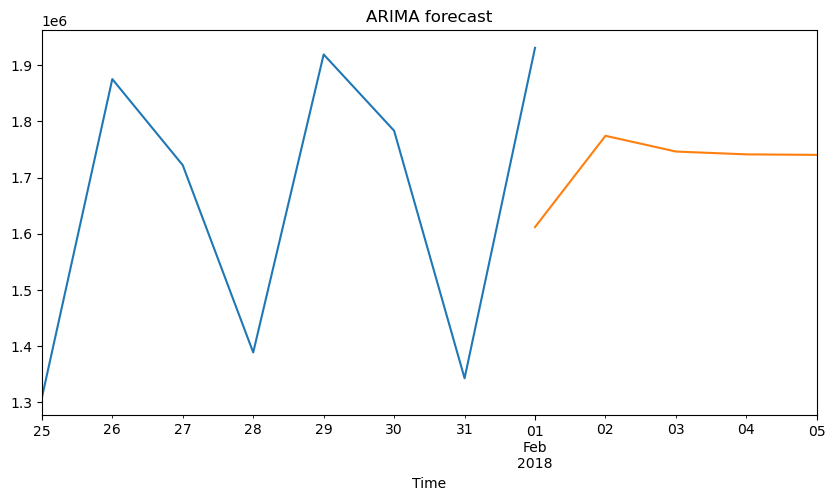

In [36]:
currency.GEMS_GEMS_SPENT['2018-01-25':'2018-02-01'].plot(figsize=(10, 5))
pred.plot()
plt.title('ARIMA forecast')
# plt.savefig('../Presentation/img/ARIMA_forecast.png')
plt.show()

# SARIMA model

In [37]:
import pmdarima as pmd

model=pmd.auto_arima(currency.GEMS_GEMS_SPENT[:'2018-02-01'],
                    start_p=1,
                    start_q=1,
                    test='adf',
                    m=12,
                    seasonal=True,
                    trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=7753.105, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7991.088, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7832.704, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7848.798, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8615.321, Time=0.00 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=7814.690, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=7756.134, Time=0.12 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=7748.798, Time=0.28 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7747.116, Time=0.21 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=7877.819, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7833.359, Time=0.16 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=7707.633, Time=0.31 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=7726.445, Time=0.18 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=7708.003, Time=0.37 sec
 ARIMA(2,0,1)(1,0,1

In [38]:
pred = model.predict(10)

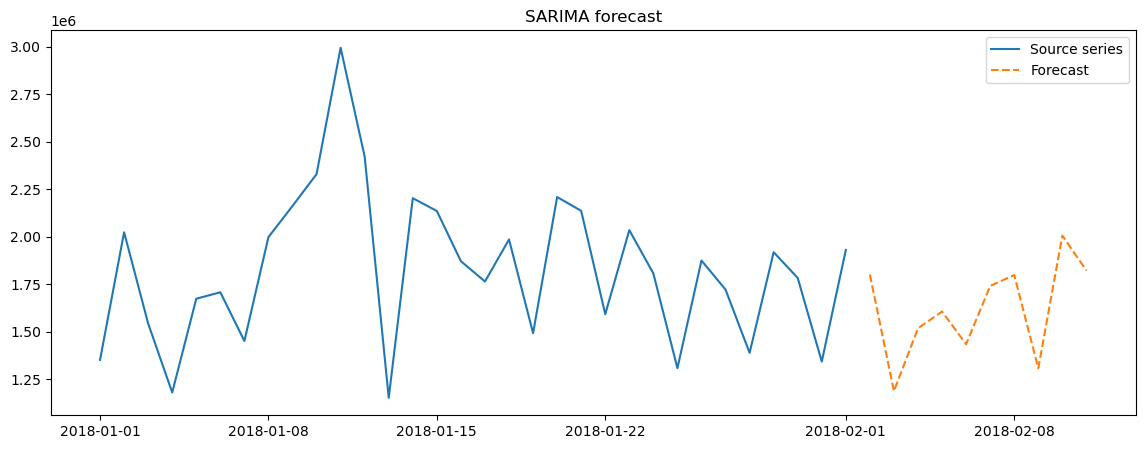

In [45]:
plt.figure(figsize=(14, 5))
plt.plot(currency.GEMS_GEMS_SPENT['2018-01-01':'2018-02-01'], label='Source series')
plt.plot(pred, linestyle='--', label='Forecast')
plt.title('SARIMA forecast')
plt.legend()
# plt.savefig('../Presentation/img/SARIMA_forecast.png')
plt.show()

In [48]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)



parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

Внимание! Работает очень долго.

In [50]:
# results = []
# best_aic = float("inf")

# for param in tqdm(parameters_list):
#     #try except нужен, потому что на некоторых наборах параметров модель не обучается
#     try:
#         model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT[:'2018-02-01'], order=(param[0], d, param[1]), 
#                                         seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
#     #выводим параметры, на которых модель не обучается и переходим к следующему набору
#     except ValueError:
#         print('wrong parameters:', param)
#         continue
#     aic = model.aic
#     #сохраняем лучшую модель, aic, параметры
#     if aic < best_aic:
#         best_model = model
#         best_aic = aic
#         best_param = param
#     results.append([param, model.aic])


# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/100 [00:00<?, ?it/s]/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  1%|          | 1/100 [00:06<10:53,  6.60s/it]/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/U

KeyboardInterrupt: 

# XGBoost model

Подробнее можно прочитать: https://medium.com/@redeaddiscolll/forecasting-stock-prices-with-xgboost-0b79fdcdd9ae

In [122]:
#### Input params ##################
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [56]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [87]:
df = yf.Ticker("VTI").history(start="2016-01-01", period='1d')

In [88]:
df.reset_index(inplace=True)
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df.date.dt.month
df.drop(columns=['dividends', 'stock_splits', 'capital_gains'], inplace=True)
df.head()

,date,open,high,low,close,volume,month
0,2016-01-04 00:00:00-05:00,89.258220,89.580165,88.388087,89.397438,6138300,1
1,2016-01-05 00:00:00-05:00,89.536663,89.780299,89.014585,89.597572,3652300,1
2,2016-01-06 00:00:00-05:00,88.344591,88.953688,87.839913,88.396797,3732800,1
3,2016-01-07 00:00:00-05:00,86.926257,87.709378,86.030022,86.230148,9256200,1
4,2016-01-08 00:00:00-05:00,86.673935,87.004583,85.081590,85.246918,7015800,1


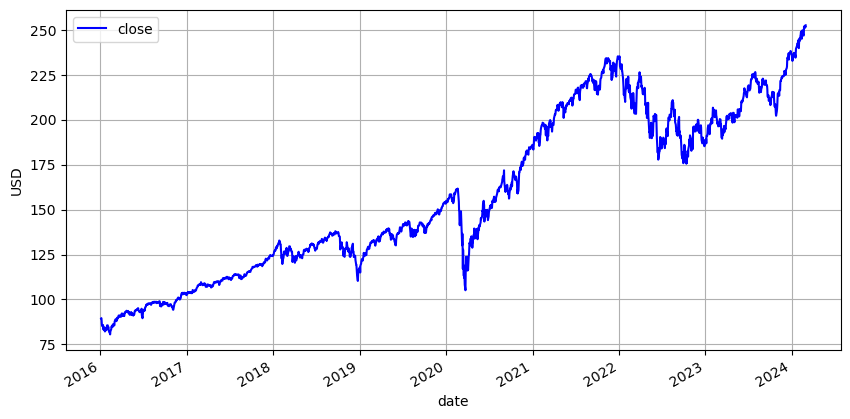

In [89]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 5 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.show()

In [90]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open'], axis=1, inplace=True)

# df.head()

,date,close,volume,month,range_hl,range_oc
0,2016-01-04 00:00:00-05:00,89.397438,6138300,1,1.192078,-0.139218
1,2016-01-05 00:00:00-05:00,89.597572,3652300,1,0.765714,-0.060909
2,2016-01-06 00:00:00-05:00,88.396797,3732800,1,1.113776,-0.052206
3,2016-01-07 00:00:00-05:00,86.230148,9256200,1,1.679356,0.696109
4,2016-01-08 00:00:00-05:00,85.246918,7015800,1,1.922993,1.427017


In [91]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['close', 'range_hl', 'range_oc', 'volume']
lag_cols

['close', 'range_hl', 'range_oc', 'volume']

In [96]:
shift_range = [x+1 for x in range(N)]

for shift in notebook.tqdm(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
# df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,date,close,volume,month,range_hl,range_oc,order_day,close_lag_1_x,range_hl_lag_1_x,range_oc_lag_1_x,...,range_oc_lag_1,volume_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2016-01-15 00:00:00-05:00,83.062881,8101700,1,1.444417,-0.356751,9,84.846657,2.479877,-1.000654,...,-1.000654,5085100.0,83.567581,2.975854,2.575593,6163000.0,85.777718,1.644551,0.191430,4457300.0
4,2016-01-19 00:00:00-05:00,82.975883,7435700,1,1.888187,1.052860,10,83.062881,1.444417,-0.356751,...,-0.356751,8101700.0,84.846657,2.479877,-1.000654,5085100.0,83.567581,2.975854,2.575593,6163000.0
5,2016-01-20 00:00:00-05:00,82.157944,13844900,1,3.028059,-0.365454,11,82.975883,1.888187,1.052860,...,1.052860,7435700.0,83.062881,1.444417,-0.356751,8101700.0,84.846657,2.479877,-1.000654,5085100.0
6,2016-01-21 00:00:00-05:00,82.479881,7169500,1,1.862083,-0.078315,12,82.157944,3.028059,-0.365454,...,-0.365454,13844900.0,82.975883,1.888187,1.052860,7435700.0,83.062881,1.444417,-0.356751,8101700.0
7,2016-01-22 00:00:00-05:00,84.237541,3701500,1,0.817927,-0.417660,13,82.479881,1.862083,-0.078315,...,-0.078315,7169500.0,82.157944,3.028059,-0.365454,13844900.0,82.975883,1.888187,1.052860,7435700.0


In [97]:
cols_list = [
"close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
# df.head()

,date,close,volume,month,range_hl,range_oc,order_day,close_lag_1_x,range_hl_lag_1_x,range_oc_lag_1_x,...,range_oc_lag_3,volume_lag_3,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2016-01-15 00:00:00-05:00,83.062881,8101700,1,1.444417,-0.356751,9,84.846657,2.479877,-1.000654,...,0.191430,4457300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-19 00:00:00-05:00,82.975883,7435700,1,1.888187,1.052860,10,83.062881,1.444417,-0.356751,...,2.575593,6163000.0,83.062881,NaN,1.444417,NaN,-0.356751,NaN,8.101700e+06,NaN
5,2016-01-20 00:00:00-05:00,82.157944,13844900,1,3.028059,-0.365454,11,82.975883,1.888187,1.052860,...,-1.000654,5085100.0,83.019382,0.061517,1.666302,0.313793,0.348055,0.996746,7.768700e+06,4.709331e+05
6,2016-01-21 00:00:00-05:00,82.479881,7169500,1,1.862083,-0.078315,12,82.157944,3.028059,-0.365454,...,-0.356751,8101700.0,82.732236,0.499251,2.120221,0.816921,0.110218,0.816363,9.794100e+06,3.523865e+06
7,2016-01-22 00:00:00-05:00,84.237541,3701500,1,0.817927,-0.417660,13,82.479881,1.862083,-0.078315,...,1.052860,7435700.0,82.537903,0.412045,2.259443,0.665769,0.203030,0.749847,9.483367e+06,3.779543e+06


In [98]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1228
num_cv = 408
num_test = 408
train.shape = (1228, 51)
cv.shape = (408, 51)
train_cv.shape = (1636, 51)
test.shape = (408, 51)


In [99]:
cols_to_scale = [
"close"
]

for i in range(1,N+1):
    cols_to_scale.append("close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
# print("scaler.mean_ = " + str(scaler.mean_))
# print("scaler.var_ = " + str(scaler.var_))
# print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
# print("train_scaled.shape = " + str(train_scaled.shape))
# train_scaled.head()

scaler.mean_ = [ 1.24887399e+02  1.24811739e+02  1.34620693e+00 -2.30557227e-03
  3.09862321e+06  1.24733889e+02  1.34809529e+00 -1.69426795e-04
  3.10222296e+06  1.24658351e+02  1.34857390e+00  4.07397777e-05
  3.10303559e+06]
scaler.var_ = [4.65515843e+02 4.64539428e+02 1.47588939e+00 1.12651344e+00
 4.99139911e+12 4.63512689e+02 1.47766162e+00 1.13191890e+00
 4.99753545e+12 4.62385364e+02 1.47766387e+00 1.13194515e+00
 4.99892620e+12]
train_scaled.shape = (1228, 13)
train_scaled.shape = (1228, 15)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.938491,-1.854255,0.933168,-0.940620,0.889145,-1.912102,1.339067,2.421019,1.369159,-1.808137,0.243484,0.179889,0.605711,2016-01-15 00:00:00-05:00,1
1,-1.942523,-1.937016,0.080841,-0.333950,2.239371,-1.852691,0.931055,-0.940379,0.886988,-1.910919,1.338673,2.420793,1.368605,2016-01-19 00:00:00-05:00,1
2,-1.980433,-1.941053,0.446125,0.994151,1.941270,-1.935545,0.079239,-0.335159,2.236385,-1.851436,0.930660,-0.940565,0.886501,2016-01-20 00:00:00-05:00,1
3,-1.965512,-1.979003,1.384397,-0.342150,4.810020,-1.939586,0.444304,0.989767,1.938468,-1.934390,0.078845,-0.335353,2.235711,2016-01-21 00:00:00-05:00,1
4,-1.884047,-1.964066,0.424638,-0.071615,1.822119,-1.977577,1.382014,-0.343340,4.805456,-1.938436,0.443910,0.989558,1.937835,2016-01-22 00:00:00-05:00,1


In [100]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
# print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
# print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
# print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
# print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
# train_cv_scaled.head()

scaler_train_cv.mean_ = [1.45903197e+02 1.45840272e+02 1.69386649e+00 1.73647057e-02
 3.36902628e+06 1.45778753e+02 1.69353294e+00 1.98692064e-02
 3.37074230e+06 1.45718084e+02 1.69233198e+00 2.11131645e-02
 3.37143600e+06]
scaler_train_cv.var_ = [1.73496241e+03 1.73616455e+03 2.13790973e+00 1.81306014e+00
 4.69211515e+12 1.73763110e+03 2.13687240e+00 1.81560619e+00
 4.69688367e+12 1.73888616e+03 2.13462898e+00 1.81349987e+00
 4.69760340e+12]
train_cv_scaled.shape = (1636, 13)
train_cv_scaled.shape = (1636, 15)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.508667,-1.463824,0.537569,-0.756049,0.792231,-1.492415,0.877218,1.896719,1.288400,-1.437420,-0.032704,0.126474,0.500999,2016-01-15 00:00:00-05:00,1
1,-1.510755,-1.506634,-0.170603,-0.277843,2.184853,-1.461731,0.537927,-0.757377,0.791037,-1.490421,0.878500,1.896897,1.287981,2016-01-19 00:00:00-05:00,1
2,-1.530392,-1.508722,0.132900,0.769028,1.877392,-1.504522,-0.170417,-0.279507,2.182952,-1.459748,0.539032,-0.758740,0.790656,2016-01-20 00:00:00-05:00,1
3,-1.522663,-1.528352,0.912481,-0.284307,4.836219,-1.506609,0.133160,0.766630,1.875647,-1.502525,-0.169684,-0.280593,2.182465,2016-01-21 00:00:00-05:00,1
4,-1.480466,-1.520626,0.115047,-0.071058,1.754500,-1.526231,0.912930,-0.285966,4.832971,-1.504611,0.134052,0.766151,1.875183,2016-01-22 00:00:00-05:00,1


In [101]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in notebook.tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
# cv_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,date,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1231,2020-12-01 00:00:00-05:00,-1.034035,0.962078,0.071958,1.128854,-0.774824,-0.354030,1.154614,-0.565099,-0.589516,0.695077,-1.146069,0.450992
1232,2020-12-02 00:00:00-05:00,0.907698,-1.071962,0.164264,-0.329555,1.123185,-0.793630,-0.477802,1.149274,-0.671472,0.637555,0.514975,-1.152530
1233,2020-12-03 00:00:00-05:00,0.632892,0.519966,-1.152858,-0.336589,-0.788278,1.124867,-0.938012,-0.114175,1.052187,0.324111,0.797744,-1.121854
1234,2020-12-04 00:00:00-05:00,1.105630,-0.264394,-0.841236,-0.155447,1.068621,-0.913173,0.082201,-1.038564,0.956362,1.152920,-0.631967,-0.520953
1235,2020-12-07 00:00:00-05:00,1.140648,-0.414787,-0.725861,0.688247,-1.147079,0.458832,-1.054410,0.934838,0.119573,0.566446,0.588186,-1.154632


In [103]:
# Do scaling for test set
test_scaled = test[['date']]
for col in notebook.tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
# test_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,date,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1639,2022-07-18 00:00:00-04:00,1.126818,-0.781838,-0.344979,-1.151733,0.504217,0.647516,0.943460,0.104823,-1.048282,-1.152060,0.643622,0.508437
1640,2022-07-19 00:00:00-04:00,0.181205,0.897008,-1.078212,0.906051,-1.072948,0.166896,1.153498,-0.531115,-0.622383,1.050961,-0.939740,-0.111221
1641,2022-07-20 00:00:00-04:00,1.121175,-0.799805,-0.321369,0.258331,0.845488,-1.103819,-0.847425,1.102979,-0.255554,-0.194609,1.083000,-0.888391
1642,2022-07-21 00:00:00-04:00,0.782334,0.344336,-1.126670,-1.088188,0.209602,0.878586,-0.323971,-0.797849,1.121820,-0.517925,-0.634803,1.152727
1643,2022-07-22 00:00:00-04:00,1.032872,-0.069355,-0.963517,0.460163,-1.147244,0.687081,0.021229,0.989216,-1.010446,-1.148722,0.675985,0.472737


In [104]:
features = []
for i in range(1,N+1):
    features.append("close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
# print("X_train.shape = " + str(X_train.shape))
# print("y_train.shape = " + str(y_train.shape))
# print("X_cv.shape = " + str(X_cv.shape))
# print("y_cv.shape = " + str(y_cv.shape))
# print("X_train_cv.shape = " + str(X_train_cv.shape))
# print("y_train_cv.shape = " + str(y_train_cv.shape))
# print("X_sample.shape = " + str(X_sample.shape))
# print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1228, 12)
y_train.shape = (1228,)
X_cv.shape = (408, 12)
y_cv.shape = (408,)
X_train_cv.shape = (1636, 12)
y_train_cv.shape = (1636,)
X_sample.shape = (408, 12)
y_sample.shape = (408,)


In [105]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
# print("X_train_scaled.shape = " + str(X_train_scaled.shape))
# print("y_train_scaled.shape = " + str(y_train_scaled.shape))
# print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
# print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
# print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
# print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1228, 12)
y_train_scaled.shape = (1228,)
X_cv_scaled.shape = (408, 12)
X_train_cv_scaled.shape = (1636, 12)
y_train_cv_scaled.shape = (1636,)
X_sample_scaled.shape = (408, 12)


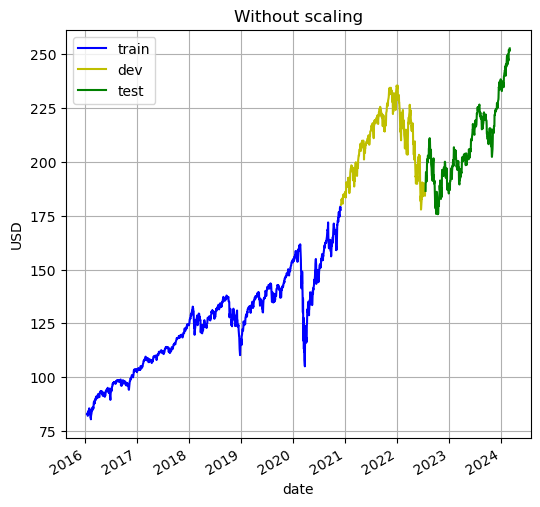

In [136]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 6, 6 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")
# plt.savefig('../Presentation/img/VTI.png')
plt.show()

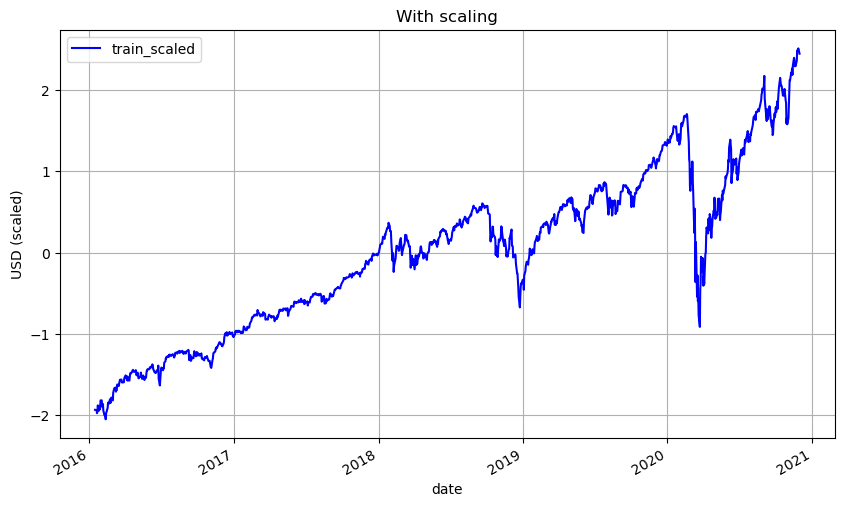

In [109]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 6 # width 10, height 8

ax = train_scaled.plot(x='date', y='close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")
plt.show()

In [110]:
# Create the model
model = XGBRegressor(seed=model_seed,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    min_child_weight=min_child_weight,
                    subsample=subsample,
                    colsample_bytree=colsample_bytree,
                    colsample_bylevel=colsample_bylevel,
                    gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [111]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.980
MAPE on train set = 0.532%


Text(0.5, 1.0, 'Without scaling')

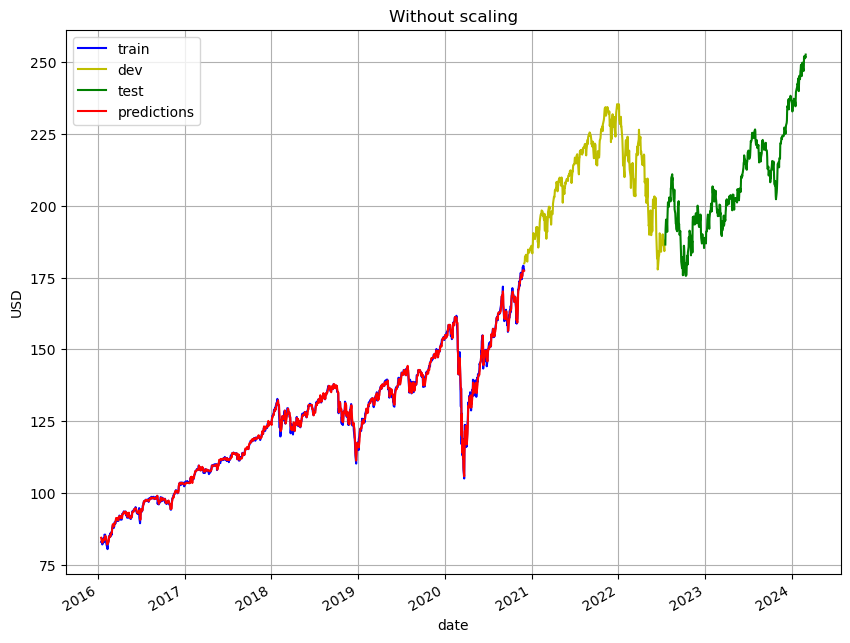

In [112]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                        'date': train['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [113]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 2.495
MAPE on dev set = 0.914%


/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_94231/3555681643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_94231/3555681643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']


Text(0, 0.5, 'USD')

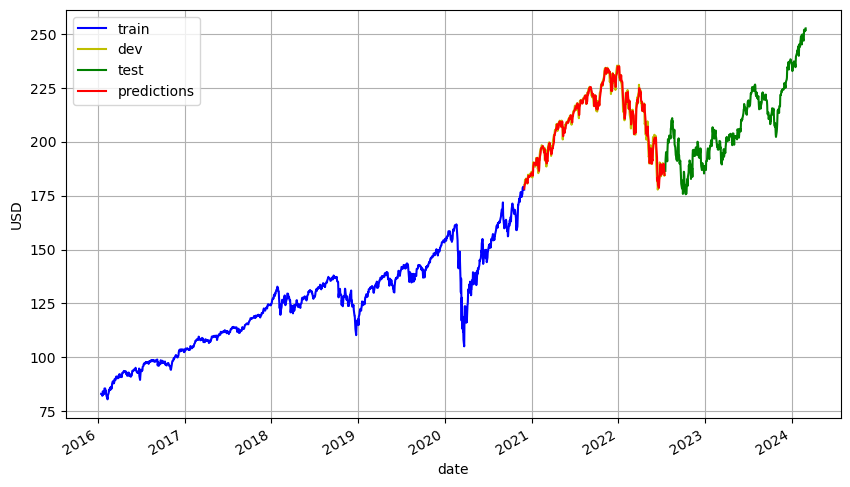

In [115]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 6 # width 10, height 6

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

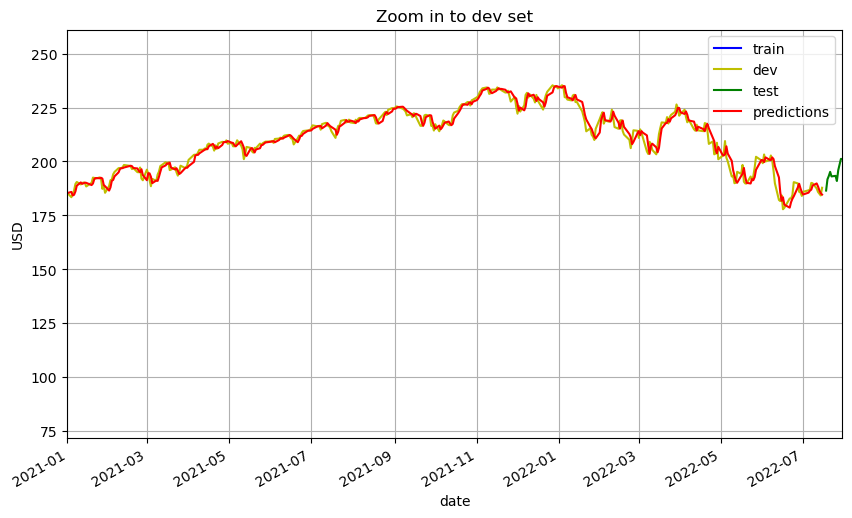

In [118]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 6 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 1, 1), date(2022, 7, 30)])
ax.set_title("Zoom in to dev set")
plt.show()

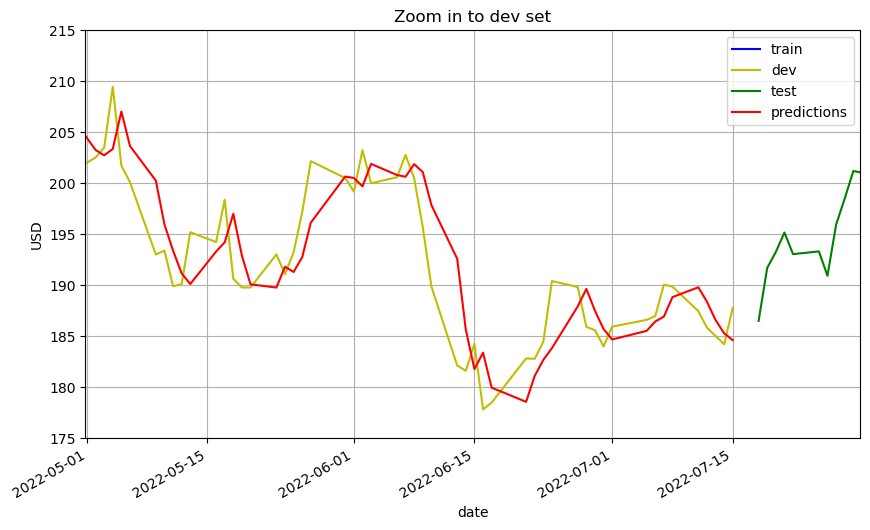

In [120]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 6 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([175, 215]) # set y-axis limits from 0 to 1
ax.set_xlim([date(2022, 5, 1), date(2022, 7, 30)])
ax.set_title("Zoom in to dev set")
plt.show()

In [121]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_hl_lag_3', 0.00058136944),
 ('volume_lag_1', 0.00070559426),
 ('range_hl_lag_1', 0.00072199485),
 ('volume_lag_3', 0.00074950146),
 ('range_oc_lag_2', 0.0007817744),
 ('volume_lag_2', 0.0008062379),
 ('range_hl_lag_2', 0.0010910255),
 ('close_lag_3', 0.034825485),
 ('close_lag_1', 0.31583256),
 ('close_lag_2', 0.64291984)]

In [124]:
#### Input params ##################

n_estimators_opt = 100             # Number of boosted trees to fit. default = 100
max_depth_opt = 3                  # Maximum tree depth for base learners. default = 3
learning_rate_opt = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight_opt = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample_opt = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree_opt = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel_opt = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma_opt = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

In [125]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['close_mean'],
                             test['close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2.191
MAPE on test set = 0.842%


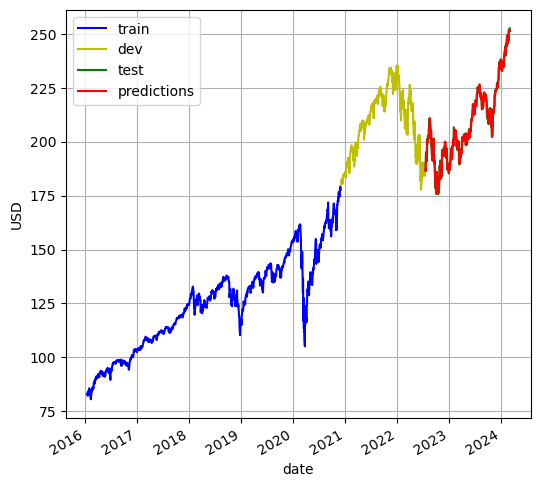

In [137]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 6, 6 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
# plt.savefig('../Presentation/img/VTI_forecast.png', dpi=300)

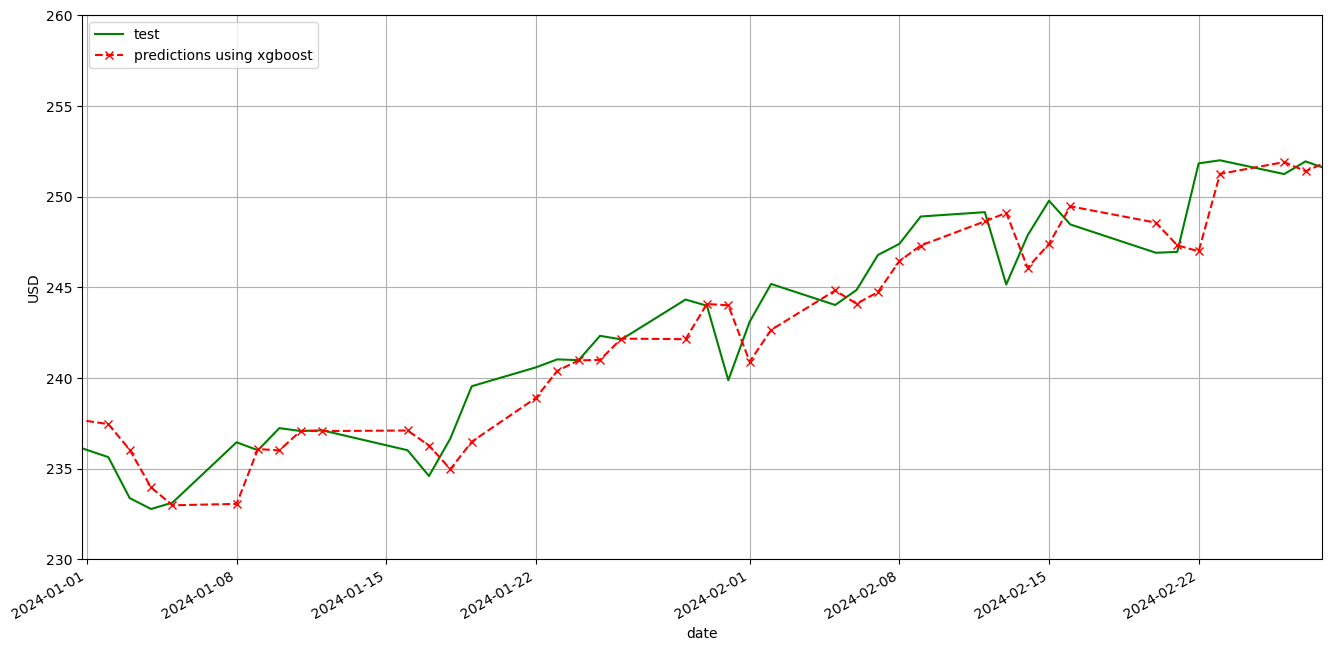

In [141]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 16, 8 # width 10, height 8
# plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx--', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2024, 1, 1), date(2024, 2, 28)])
ax.set_ylim([230, 260])
# plt.savefig('../Presentation/img/VTI_predictions_zoom.png')
plt.show()